<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Training a Multi-Object Tracking Model

In this notebook, we give an introduction to training a multi-object tracking model using [torchvision](https://pytorch.org/docs/stable/torchvision/index.html). Using a small dataset, we demonstrate how to train and evaluate a one-shot multi-object tracking model, which detects objects and learns their re-ID features. In particular, we will use FairMOT, the one-shot tracking model developed by MSR Asia and others in this [repo](https://github.com/ifzhang/FairMOT). We will train the model on a set of still images, then evaluate on a video. We also show how to save and load the trained model for inference on a second video. 

To learn more about how multi-object tracking works, visit our [FAQ](./FAQ.md).


## Initialization
Import all the functions we need.

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Regular python libraries
import os
from pathlib import Path
import sys
import time

from PIL import Image
import matplotlib.pyplot as plt
import scrapbook as sb
from ipywidgets import Video

# Pytorch
import torch
import torchvision

# Computer Vision repository
sys.path.append("../../")
#from utils_cv.multi_object_tracking.display_with_bb import convert_trackingbboxes_video
#from utils_cv.multi_object_tracking.file_format import convert_vott_MOTxywh 
from utils_cv.tracking.dataset import TrackingDataset 
from utils_cv.tracking.model import TrackingLearner 
from utils_cv.common.gpu import which_processor, is_windows

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0a0+6b959ee
Torch is using GPU: Tesla K80


This shows your machine's GPUs (if it has any) and the computing device `torch/torchvision` is using.

Next, set the data input, some model runtime parameters and inference parameters.

In [3]:
# Datasets 
DATA_PATH_TRAIN = "./data/odFridgeObjects_FairMOTformat/" #unzip_url(Urls.fridge_objects_path, exist_ok=True) #TODO
DATA_PATH_EVAL_VIDEO = "./data/carcans_1s.mp4" #unzip_url(Urls.fridge_objects_path, exist_ok=True) #TODO
DATA_PATH_EVAL_VOTT = "./data/carcans_vott-csv-export/" #unzip_url(Urls.fridge_objects_path, exist_ok=True) #TODO
DATA_PATH_EVAL = "./data/carcans_MOTformat/" #unzip_url(Urls.fridge_objects_path, exist_ok=True) #TODO
DATA_PATH_TEST = "./data/carcans_8s.mp4" #unzip_url(Urls.fridge_objects_path, exist_ok=True) #TODO
FRAME_RATE = 30 # frame rate  for 1st inference video
FRAME_RATE_2 = 30 # frame rate  for 2nd inference video

# Model parameters
EPOCHS = 3
BATCH_SIZE = 1
LEARNING_RATE = 0.0001
SAVE_MODEL = True

# Inference parameters
CONF_THRES = 0.6 ; TRACK_BUFFER = FRAME_RATE*10
INPUT_W = 1920; INPUT_H = 1080

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")

Using torch device: cuda


## Prepare Training Dataset

In this section, for the training data, we use a toy dataset called *Fridge Objects*, which consists of 134 images of 4 classes of beverage container `{can, carton, milk bottle, water bottle}` photos taken on different backgrounds, as used for the object detection scenario. This will serve as a simple illustration of how finetuning a pre-trained tracking model with a small dataset to enhance its tracking performance.

Similar to the object detection [training introduction notebook](../detection/01_training_introduction.ipynb), we use the helper function downloads and unzips data set to the `ComputerVision/data` directory. #TODO: correct if needed

Set that directory in the `path` variable for ease of use throughout the notebook.

In [4]:
DATA_PATH_TRAIN = "./data/odFridgeObjects_FairMOTformat/"
os.listdir(DATA_PATH_TRAIN)

['images', 'labels_with_ids', '.ipynb_checkpoints', 'default.train']

#TODO, in future versions will change input format so that it's in usual Pascal VOC xml format, not FairMOt format below. 

You'll notice that we have two different folders inside:
- `/images/`
- `/labels_with_ids/`

This format of having 2 folders, one for images and one for labels, is fairly common for object detection and object tracking. Compared to object detection, for object tracking, the 'labels_with_ids' files have a field for the id number. 

```
/data
+-- images
|   +-- 00001.jpg
|   +-- 00002.jpg
|   +-- ...
+-- labels_with_ids
|   +-- 00001.txt
|   +-- 00002.txt
|   +-- ...
+-- ...
```

Each image corresponds to a txt file, which must have a similar name, e.g. txt file '00128.txt' contains detections and tracking  information in image file '00128.jpg', i.e. it contains the bounding boxes and the object ids information. In this example, our fridge object dataset is annotated in the format followed by the [FairMOT repo](https://github.com/ifzhang/FairMOT), originally from the [Towards-Realtime-MOT repo](https://github.com/Zhongdao/Towards-Realtime-MOT/blob/master/DATASET_ZOO.md). For example, '00128.txt' contains the following:

```
0 3 0.35671 0.50450 0.17635 0.23724
0 2 0.67335 0.49399 0.36874 0.57057

```
This follows the FairMOT file format, where each line describes a bounding box as follows, as described in [Towards-Realtime-MOT repo](https://github.com/Zhongdao/Towards-Realtime-MOT/blob/master/DATASET_ZOO.md):
```
[class] [identity] [x_center] [y_center] [width] [height]
```
The field `class` is set to 0, for all, as only single-class multi-object tracking is currently supported by the [FairMOT repo](https://github.com/ifzhang/FairMOT). The field `identity` is an integer from `0` to `num_identities - 1`. In this training dataset, we used this dictionary to convert the original class-labels to ids: `{'milk_bottle': 0, 'water_bottle': 1, 'carton': 2, 'can': 3}`. The values of ` [x_center] [y_center] [width] [height]` are normalized by the width/height of the image, and range from `0` to `1`. 

## Load Training Dataset

To load the data, we need to create a Torchvision dataset object class using our `TrackingDataset` class wrapper, that also converts the dataset into the appropriate formats.

In [5]:
data_train = TrackingDataset(
    DATA_PATH_TRAIN,
    batch_size=BATCH_SIZE
)

dataset summary
OrderedDict([('default', 4.0)])
total # identities: 5
start index
OrderedDict([('default', 0)])


## Finetune a Pretrained Model

For the TrackingLearner, we use FairMOT's baseline tracking model. FairMOT's baseline tracking model is pre-trained on pedestrian datasets, such as in the [MOT challenge datasets](https://motchallenge.net/). Hence, it does not even detect fridge objects, such as the in the evaluation video.

When we initialize the TrackingLearner, we can pass in the training dataset. By default, the object will set the model to FairMOT's baseline tracking model.

In [6]:
tracker = TrackingLearner(data_train) 
print(f"Model: {type(tracker.model)}")

Model: <class 'utils_cv.tracking.references.fairmot.models.networks.pose_dla_dcn.DLASeg'>


To run the training, we call the `fit` method in the tracker object. The main fit parameters include `num_epochs`, `lr` and`batch_size` which was passed on to our `TrackingDataset` object above. 

In [7]:
tracker.fit(num_epochs=EPOCHS, lr=LEARNING_RATE)

Training in epoch  1 ...


/data/anaconda/envs/cv/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Training in epoch  2 ...
Training in epoch  3 ...


We can now generate losses over the training epochs, and see how the model improves with training. We want to run the training for an appropriate `num_epochs` and `lr` (to be fine-tuned by the user) that produces a loss-curve that tails off. The loss-curve for our training is as follows:

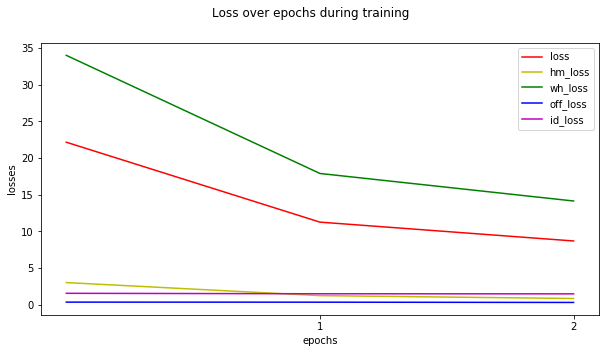

In [8]:
tracker.plot_training_losses()